In [22]:
import pandas as pd
# Read flight data from spreadsheet to 'pandas' model
# read_csv returns a DataFrame (two-D data structure with labeled axes)
flight_data = pd.read_csv('ONTIME_FLIGHT_DATA.csv')
flight_data.head()

,YEAR,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN_AIRPORT_ID,ORIGIN_AIRPORT_SEQ_ID,ORIGIN_CITY_MARKET_ID,ORIGIN,DEST_AIRPORT_ID,DEST_AIRPORT_SEQ_ID,DEST_CITY_MARKET_ID,DEST,CRS_DEP_TIME,ARR_DELAY_NEW,ARR_DEL15,Unnamed: 15
0,2019,1,19,6,13487,1348702,31650,MSP,11193,1119302,33105,CVG,1556,0.0,0.0,NaN
1,2019,1,20,7,13487,1348702,31650,MSP,11193,1119302,33105,CVG,1556,0.0,0.0,NaN
2,2019,1,21,1,13487,1348702,31650,MSP,11193,1119302,33105,CVG,1556,0.0,0.0,NaN
3,2019,1,22,2,13487,1348702,31650,MSP,11193,1119302,33105,CVG,1556,0.0,0.0,NaN
4,2019,1,23,3,13487,1348702,31650,MSP,11193,1119302,33105,CVG,1556,0.0,0.0,NaN


In [23]:
print(type(flight_data))

<class 'pandas.core.frame.DataFrame'>


# Clean Data

In [24]:
# before construct a model, need to clean data to remove null values
flight_data.isnull().values.any()

True

In [25]:
flight_data.isnull().sum()

YEAR                          0
MONTH                         0
DAY_OF_MONTH                  0
DAY_OF_WEEK                   0
ORIGIN_AIRPORT_ID             0
ORIGIN_AIRPORT_SEQ_ID         0
ORIGIN_CITY_MARKET_ID         0
ORIGIN                        0
DEST_AIRPORT_ID               0
DEST_AIRPORT_SEQ_ID           0
DEST_CITY_MARKET_ID           0
DEST                          0
CRS_DEP_TIME                  0
ARR_DELAY_NEW             21000
ARR_DEL15                 21000
Unnamed: 15              638649
dtype: int64

In [26]:
flight_data = flight_data.drop('Unnamed: 15', axis=1)

In [27]:
flight_data.isnull().sum()

YEAR                         0
MONTH                        0
DAY_OF_MONTH                 0
DAY_OF_WEEK                  0
ORIGIN_AIRPORT_ID            0
ORIGIN_AIRPORT_SEQ_ID        0
ORIGIN_CITY_MARKET_ID        0
ORIGIN                       0
DEST_AIRPORT_ID              0
DEST_AIRPORT_SEQ_ID          0
DEST_CITY_MARKET_ID          0
DEST                         0
CRS_DEP_TIME                 0
ARR_DELAY_NEW            21000
ARR_DEL15                21000
dtype: int64

In [28]:
# CRS_ARR_TIME	Scheduled arrival time; ARR_DEL15	0=Arrived less than 15 minutes late, 1=Arrived 15 minutes or more late
flight_data = flight_data[['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'ARR_DEL15']]

In [29]:
flight_data.isnull().sum()

MONTH               0
DAY_OF_MONTH        0
DAY_OF_WEEK         0
ORIGIN              0
DEST                0
CRS_DEP_TIME        0
ARR_DEL15       21000
dtype: int64

In [30]:
flight_data.shape

(638649, 7)

In [31]:
flight_data = flight_data.fillna({'ARR_DEL15': 1}) # fill NA values with '1' in ARR_DEL15 column

In [32]:
import numpy as np
# In order to avoid overfitting, divide CRS_DEP_TIME:scheduled arrival time by 100 because it matters more if flight is delayed by hours rather than by a minutes
flight_data['CRS_DEP_TIME'] = flight_data['CRS_DEP_TIME'].div(100).apply(np.floor)

In [33]:
flight_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,ORIGIN,DEST,CRS_DEP_TIME,ARR_DEL15
0,1,19,6,MSP,CVG,15.0,0.0
1,1,20,7,MSP,CVG,15.0,0.0
2,1,21,1,MSP,CVG,15.0,0.0
3,1,22,2,MSP,CVG,15.0,0.0
4,1,23,3,MSP,CVG,15.0,0.0


In [34]:
# Create dummies for 'ORIGIN' and 'DEST' columns
# These columns need to be converted into discrete columns containing indicator variables, sometimes known as "dummy" variables. 
# With each column containing 1s and 0s indicating whether a flight originated at the airport that the column represents. 
flight_data = pd.get_dummies(flight_data, columns=['ORIGIN', 'DEST'])
flight_data.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,CRS_DEP_TIME,ARR_DEL15,ORIGIN_ABE,ORIGIN_ABI,ORIGIN_ABQ,ORIGIN_ABR,ORIGIN_ABY,...,DEST_UIN,DEST_USA,DEST_VEL,DEST_VLD,DEST_VPS,DEST_WRG,DEST_XNA,DEST_YAK,DEST_YKM,DEST_YUM
0,1,19,6,15.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,20,7,15.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,21,1,15.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,22,2,15.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,23,3,15.0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Build Machine Learning Model

In [35]:
import math
flight_data_first_quarter = flight_data[: math.floor(len(flight_data.index)/4)]
flight_data_first_quarter.shape

(159662, 725)

In [36]:
from sklearn.model_selection import train_test_split
# Split DataFrame: flight data into a training set containing 80% of the original data, and a test set containing the remaining 20%
# The random_state parameter seeds the random-number generator used to do the splitting, while the first and second parameters are DataFrames containing the feature columns and the label column.
train_x, test_x, train_y, test_y = train_test_split(flight_data_first_quarter.drop('ARR_DEL15', axis=1), flight_data_first_quarter['ARR_DEL15'], test_size=0.2, random_state=42)

In [37]:
train_x.shape

(127729, 724)

In [38]:
train_y.shape

(127729,)

In [39]:
test_x.shape

(31933, 724)

In [40]:
test_y.shape

(31933,)

# Train a classification model

In [122]:
# In this project predicting the probability of a flight will deplay, model will be a binary classification model that predicts 
# whether a flight will arrive on-time or late ("binary" because there are only two possible outputs).
# Use RandomForestClassifier which fits multiple decision trees to the data and uses averaging to boost the overall accuracy and limit overfitting.
from sklearn.ensemble import RandomForestClassifier

In [123]:
from sklearn.metrics import mean_absolute_error
def get_mae(max_leaf_nodes, n_estimators, train_x, test_x, train_y, test_y):
    model = RandomForestClassifier(max_leaf_nodes=max_leaf_nodes, n_estimators=n_estimators, random_state=3)
    model.fit(train_x, train_y)
    preds_val = model.predict(test_x)
    mae = mean_absolute_error(test_y, preds_val)
    return(mae)

In [131]:
# compare MAE with differing values of max_leaf_nodes
scores = {leaf_size: get_mae(leaf_size, 30, train_x, test_x, train_y, test_y) for leaf_size in [100, 500, 1000, 2000, 2500, 5000, 10000, 50000]}

In [132]:
best_tree_size = min(scores, key=scores.get)
print(best_tree_size)

10000


In [133]:
# 'n_estimators' is the number of trees in the forest
model = RandomForestClassifier(random_state=3, max_leaf_nodes=best_tree_size)
model.fit(train_x, train_y)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=10000,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [134]:
predicted = model.predict(test_x)
model.score(test_x, test_y)

0.8162402530297811

In [135]:
# One of the best overall measures for a binary classification model is Area Under Receiver Operating Characteristic Curve
# (sometimes referred to as "ROC AUC"), which essentially quantifies how often the model will make a correct prediction 
# regardless of the outcome. 
# Compute an ROC AUC score for the model

#from sklearn.metrics import roc_auc_score
probabilities = model.predict_proba(test_x)

In [136]:
roc_auc_score(test_y, probabilities[:, 1])

0.7486295016551348

In [137]:
# The output from the score method reflects how many of the items in the test set the model predicted correctly. 
# This score is skewed by the fact that the dataset the model was trained and tested with contains 
# many more rows representing on-time arrivals than rows representing late arrivals. 
# Because of this imbalance in the data, it's more likely to be correct if you predict that a flight will be on time than if you predict that a flight will be late.
# ROC AUC takes this into account and provides a more accurate indication of how likely it is that a prediction of on-time or late will be correct.

# Confusion Matrix

In [138]:
# The confusion matrix quantifies the number of times each answer 
# was classified correctly or incorrectly. Specifically, it quantifies the 
# number of false positives, false negatives, true positives, and true negatives.

In [139]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_y, predicted)

array([[24185,   715],
       [ 5153,  1880]])

# Precison and Recall

In [140]:
from sklearn.metrics import precision_score

train_predictions = model.predict(train_x)
precision_score(train_y, train_predictions)

0.9402047985649151

In [141]:
from sklearn.metrics import recall_score

recall_score(train_y, train_predictions)

0.44315659679408137

# Visualize Output of Model

In [142]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

Text(0, 0.5, 'True Positive Rate')

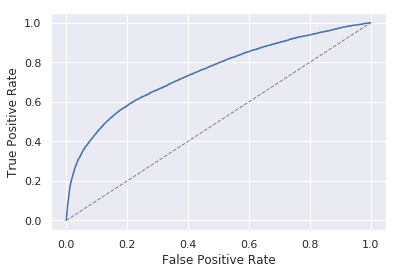

In [143]:
from sklearn.metrics import roc_curve

fpr, tpr, _ = roc_curve(test_y, probabilities[:, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

In [144]:
def insertCode(origin, destinatation):
    origin = 'ORIGIN_' + origin
    destinatation = 'DEST_' + destinatation
    # Create a dict of airports with initial value 0
    airportDict = {}
    for code in train_x.columns.tolist()[4:]:
        airportDict[code] = 0
    airportDict[origin] = 1
    airportDict[destinatation] = 1
    return airportDict

In [145]:
def predict_delay(departure_date_time, origin, destination):
    from datetime import datetime
    
    try:
        departure_date_time_parsed = datetime.strptime(departure_date_time, '%d/%m %H:%M')
    except ValueError as e:
        return 'Error parsing date/time - {}'.format(e)
    
    month = departure_date_time_parsed.month
    day = departure_date_time_parsed.day
    day_of_week = departure_date_time_parsed.isoweekday()
    hour = departure_date_time_parsed.hour
    
    origin = origin.upper()
    destination = destination.upper()
    
    input = {'MONTH': month,
              'DAY_OF_MONTH': day,
              'DAY_OF_WEEK': day_of_week,
              'CRS_DEP_TIME': hour}
    input = [{**input, **insertCode(origin, destination)}]

    return model.predict_proba(pd.DataFrame(input))[0][0]

In [146]:
predict_delay('1/10 15:45', 'EWR', 'SEA')

0.9008042316939283

In [147]:
predict_delay('24/12 09:00', 'LAX', 'EWR')

0.9052498451781034

(0.0, 1.0)

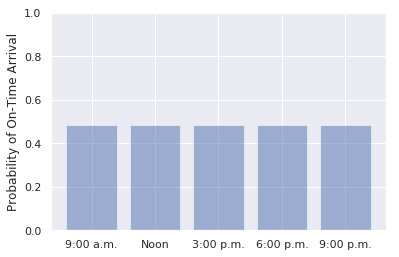

In [148]:
# flights leaving SEA for ATL at 9:00 a.m., noon, 3:00 p.m., 6:00 p.m., and 9:00 p.m. on January 30 will arrive on time
labels = ('9:00 a.m.', 'Noon', '3:00 p.m.', '6:00 p.m.', '9:00 p.m.')
values = (predict_delay('23/12 09:00', 'EWR', 'LAX'),
          predict_delay('23/12 12:00', 'EWR', 'LAX'),
          predict_delay('23/12 15:45', 'EWR', 'LAX'),
          predict_delay('23/12 18:00', 'EWR', 'LAX'),
          predict_delay('23/12 21:00', 'EWR', 'LAX'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

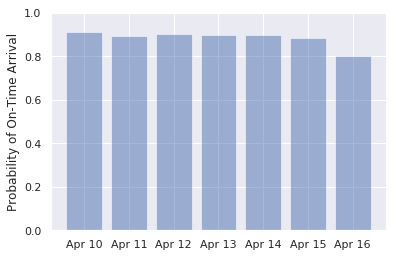

In [149]:
labels = ('Apr 10', 'Apr 11', 'Apr 12', 'Apr 13', 'Apr 14', 'Apr 15', 'Apr 16')
values = (predict_delay('10/04 13:00', 'JFK', 'MSP'),
          predict_delay('11/04 13:00', 'JFK', 'MSP'),
          predict_delay('12/04 13:00', 'JFK', 'MSP'),
          predict_delay('13/04 13:00', 'JFK', 'MSP'),
          predict_delay('14/04 13:00', 'JFK', 'MSP'),
          predict_delay('15/04 13:00', 'JFK', 'MSP'),
          predict_delay('16/04 13:00', 'JFK', 'MSP'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))

(0.0, 1.0)

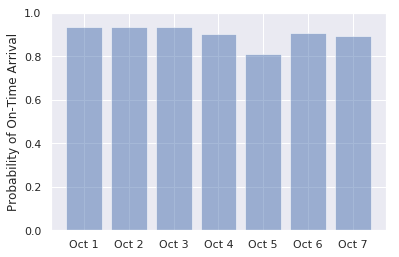

In [150]:
labels = ('Oct 1', 'Oct 2', 'Oct 3', 'Oct 4', 'Oct 5', 'Oct 6', 'Oct 7')
values = (predict_delay('1/10 21:45', 'JFK', 'ATL'),
          predict_delay('2/10 21:45', 'JFK', 'ATL'),
          predict_delay('3/10 21:45', 'JFK', 'ATL'),
          predict_delay('4/10 21:45', 'JFK', 'ATL'),
          predict_delay('5/10 21:45', 'JFK', 'ATL'),
          predict_delay('6/10 21:45', 'JFK', 'ATL'),
          predict_delay('7/10 21:45', 'JFK', 'ATL'))
alabels = np.arange(len(labels))

plt.bar(alabels, values, align='center', alpha=0.5)
plt.xticks(alabels, labels)
plt.ylabel('Probability of On-Time Arrival')
plt.ylim((0.0, 1.0))